# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [ ]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [ ]:
# Import essential libraries

from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import time
import zipfile
import sklearn
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from PIL import Image as im
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import callbacks
from PIL import Image as im
from collections import defaultdict


Load the dataset.

In [ ]:
# Mount google drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:

zip_path = '/content/drive/MyDrive/data.zip'
extract_to = '/content/data'

# Step 1: Check if the zip file exists
if os.path.exists(zip_path):
    print("✅ data.zip found!")

    # Step 2: Create extraction directory if it doesn't exist
    os.makedirs(extract_to, exist_ok=True)

    # Step 3: Extract the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    print("✅ Successfully extracted to:", extract_to)

    # Step 4: Count subfolders and list images inside
    subfolder_count = 0
    subfolder_image_counts = []

    valid_ext = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.webp')  # Define image formats

    for root, dirs, files in os.walk(extract_to):
        # Only count images in subfolders (skip the root folder)
        if root != extract_to:
            image_count = sum(1 for f in files if f.lower().endswith(valid_ext))
            if image_count > 0:
                subfolder_count += 1
                subfolder_name = os.path.basename(root)
                subfolder_image_counts.append(f"{subfolder_name}: {image_count} images")

    print(f"\n📊 {subfolder_count} subfolders found:")

    # Step 5: Print the image counts for each subfolder
    for count in subfolder_image_counts:
        print(count)

else:
    print("❌ data.zip NOT found at", zip_path)

✅ data.zip found!
✅ Successfully extracted to: /content/data

📊 7 subfolders found:
Cardboard: 540 images
Paper: 1030 images
Metal: 1000 images
Glass: 750 images
Food_Waste: 1000 images
Plastic: 2295 images
Other: 1010 images


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [ ]:
# Create a function to load the raw images

def load_raw_images(data_dir):
    """
    Loads raw images and their labels from the given directory.

    Arguments:
        data_dir(str): Path to the dataset directory.

    Returns:
        images(list): List of raw image arrays.
        labels(list): List of corresponding class labels.
    """
    images = []
    labels = []
    class_names = sorted(os.listdir(data_dir))

    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)

        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = im.open(img_path).convert('RGB')
                if img is not None:
                    images.append(img)
                    labels.append(class_name)
            except Exception as err:
                print(f"Error loading image: {img_path}, Reason: {err}")

    return images, labels

def count_images_per_class(data_dir):
    """
    Counts and prints number of images in each subdirectory (label/class).

    Args:
        data_dir (str): Path to dataset directory.
    """
    class_counts = {}

    for class_name in sorted(os.listdir(data_dir)):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            image_count = len([
                f for f in os.listdir(class_path)
                if os.path.isfile(os.path.join(class_path, f))
            ])
            class_counts[class_name] = image_count

    return class_counts

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [ ]:
# Get the images and their labels

# Step 2: Get class names
data_path = '/content/data/data'
images, labels = load_raw_images(data_path)

print(f"Total images loaded: {len(images)}")
print(f"Unique labels found: {set(labels)}")

class_counts = count_images_per_class(data_path)
print("Image count per class:\n")
for label, count in class_counts.items():
    print(f"{label:15s} : {count}")

Total images loaded: 7625
Unique labels found: {'Glass', 'Metal', 'Plastic', 'Paper', 'Cardboard', 'Food_Waste', 'Other'}
Image count per class:

Cardboard       : 540
Food_Waste      : 1000
Glass           : 750
Metal           : 1000
Other           : 1010
Paper           : 1030
Plastic         : 2295


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

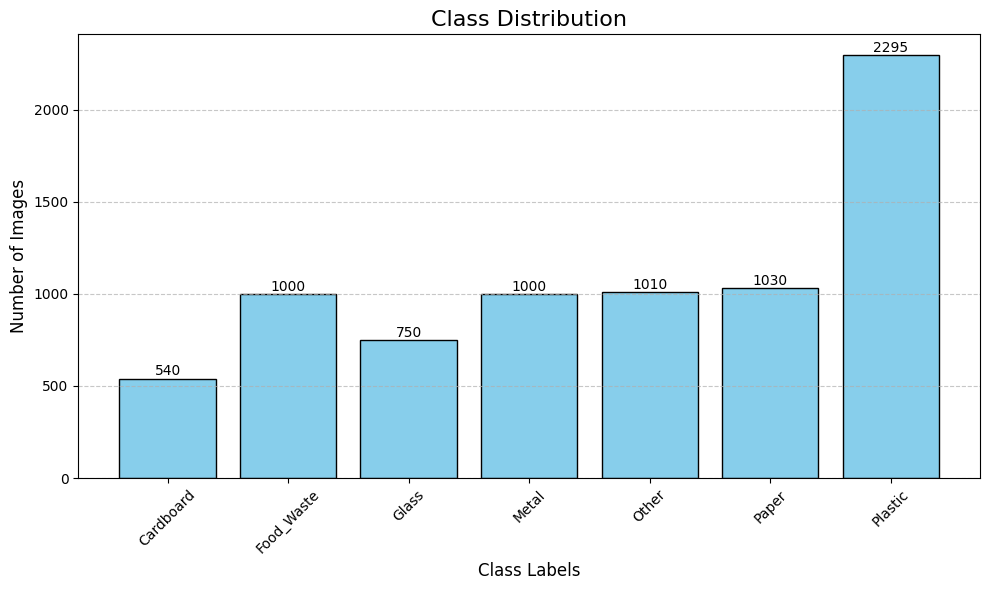

In [ ]:
# Visualise Data Distribution

classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(classes, counts, color='skyblue', edgecolor='black')

plt.title('Class Distribution', fontsize=16)
plt.xlabel('Class Labels', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add counts above the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height),
          ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

**Key Observations from the Bar Plot:**

** Imbalanced Classes

The Plastic category has the highest number of images (~2300), which means this class is overrepresented.

Cardboard has the lowest count (~550), making it the least represented class.

** Moderate Balance for Others

Classes like Food_Waste, Metal, Other, and Paper are fairly balanced (around 1000 images each).

Glass is slightly lower (~750), but not as low as Cardboard.

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

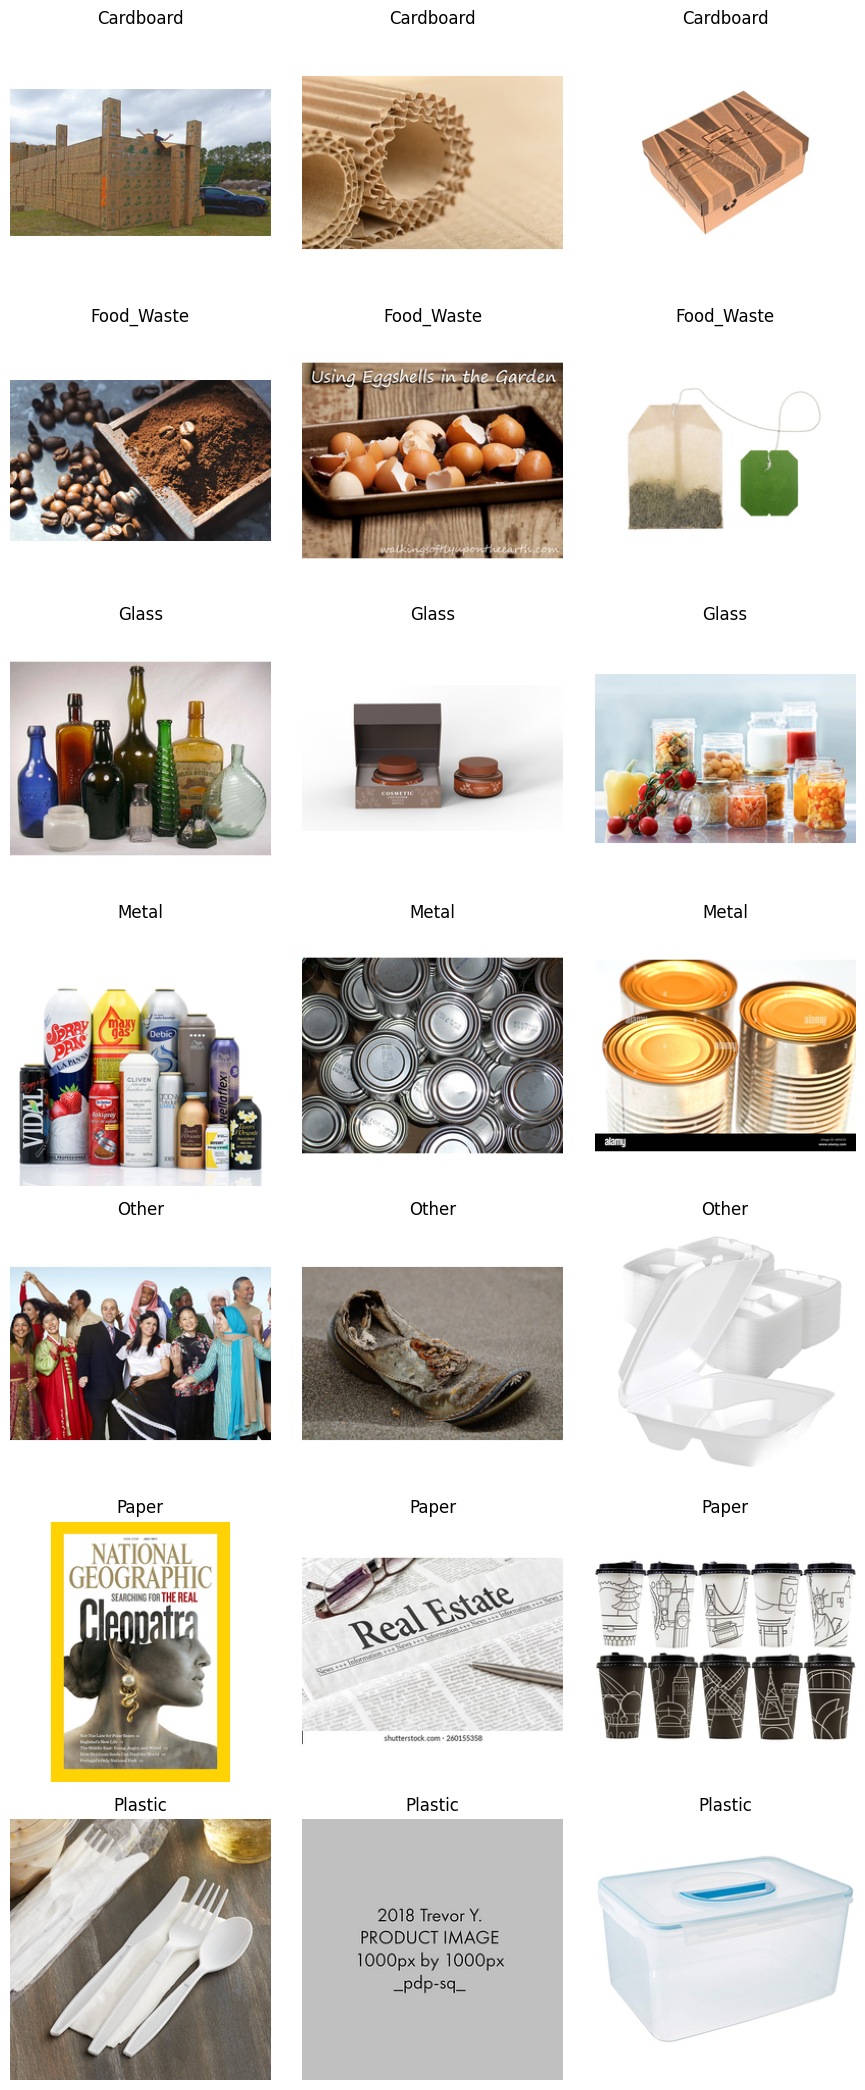

In [ ]:
# Visualise Sample Images (across different labels)

label_to_images = defaultdict(list)

for img, label in zip(images, labels):
    if len(label_to_images[label]) < 3:
        label_to_images[label].append(img)

class_names = sorted(label_to_images.keys())
num_classes = len(class_names)


plt.figure(figsize=(9, 21))

plot_index = 1
for class_name in class_names:
    for i in range(len(label_to_images[class_name])):
        plt.subplot(num_classes, 3, plot_index)
        plt.imshow(label_to_images[class_name][i])
        plt.title(f"{class_name}")
        plt.axis('off')
        plot_index += 1

plt.tight_layout()
plt.show()

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [ ]:
# Find the smallest and largest image dimensions from the data set

# Get image sizes from the PIL Image objects
image_sizes = [img.size for img in images]  # Each is (width, height)

# Find min and max by area (width * height), or by width/height separately
smallest_image = min(image_sizes, key=lambda x: x[0] * x[1])
largest_image = max(image_sizes, key=lambda x: x[0] * x[1])

print(f"Smallest image dimensions (W x H): {smallest_image}")
print(f"Largest image dimensions  (W x H): {largest_image}")


Smallest image dimensions (W x H): (256, 256)
Largest image dimensions  (W x H): (256, 256)


In [ ]:
# Resize the image dimensions
'''
It's not required to resize these images because of the following reasons:-
1. Big enough to retain important features.
2. Not too large — won’t slow training excessively.
3. Well-supported by standard CNN architectures (ResNet, VGG, MobileNet, etc.).

We might resize images only if:
1. We decide to use a pretrained model that requires a specific input size (like 224x224 for ResNet).
2. We decide to speed up training by using smaller images like 128x128 (but this might reduce accuracy).
'''
# Now after tring to train in google colab, the process is taking too long and not completing.
# So the images are being resized to a smaller size.

# Choose target size (you can adjust it based on your needs)
target_size = (128, 128)  # (width, height)

# Resize all images to target_size
resized_images = [img.resize(target_size, im.Resampling.LANCZOS) for img in images]

print(f"All images resized to: {target_size}")

All images resized to: (128, 128)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [ ]:
# Encode the labels suitably
# Step 1: Create the encoder
label_encoder = LabelEncoder()

# Step 2: Fit and transform the labels
encoded_labels = label_encoder.fit_transform(labels)

# Check results
print(f"Original labels: {labels[:]}")
print(f"Encoded labels: {encoded_labels[:]}")
print(f"Classes: {label_encoder.classes_}")

Original labels: ['Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardbo

### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up paths
data_dir = "/content/data/data"

# Create generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

Found 5338 images belonging to 7 classes.
Found 2287 images belonging to 7 classes.


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [ ]:
# Build and compile the model

# Number of output classes
num_classes = 7

model = models.Sequential([
    # 1st Conv Block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # 2nd Conv Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # 3rd Conv Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Output Layer
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # use this for integer labels
    metrics=['accuracy']
)

# Model Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,951 (12.62 MB)

 Trainable params: 3,306,247 (12.61 MB)

 Non-trainable params: 704 (2.75 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [ ]:
# Training

# Define callbacks
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stop, model_checkpoint, reduce_lr],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2737 - loss: 2.3776
Epoch 1: val_accuracy improved from -inf to 0.27897, saving model to best_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.2740 - loss: 2.3760 - val_accuracy: 0.2790 - val_loss: 2.3630 - learning_rate: 0.0010
Epoch 2/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4331 - loss: 1.6564
Epoch 2: val_accuracy improved from 0.27897 to 0.33188, saving model to best_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.4331 - loss: 1.6562 - val_accuracy: 0.3319 - val_loss: 1.7510 - learning_rate: 0.0010
Epoch 3/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5057 - loss: 1.4024
Epoch 3: val_accuracy improved from 0.33188 to 0.35986, saving model to best_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.5058 - loss: 1.4025 - val_accuracy: 0.3599 - val_loss: 1.8705 - learning_rate: 0.0010
Epoch 4/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4891 - loss: 1.4086
Epoch 4: val_accuracy improved from 0.35986 to 0.36904, saving model to best_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.4892 - loss: 1.4085 - val_accuracy: 0.3690 - val_loss: 2.7948 - learning_rate: 0.0010
Epoch 5/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5874 - loss: 1.1441
Epoch 5: val_accuracy did not improve from 0.36904

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
167/167 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - accuracy: 0.5874 - loss: 1.1441 - val_accuracy: 0.3153 - val_loss: 7.0322 - learning_rate: 0.0010
Epoch 6/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6424 - loss: 0.9875
Epoch 6: val_accuracy improved from 0.36904 to 0.39659, saving model to best_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.6424 - loss: 0.9873 - val_accuracy: 0.3966 - val_loss: 2.0941 - learning_rate: 5.0000e-04
Epoch 7/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6853 - loss: 0.8770
Epoch 7: val_accuracy improved from 0.39659 to 0.48448, saving model to best_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.6854 - loss: 0.8768 - val_accuracy: 0.4845 - val_loss: 3.5291 - learning_rate: 5.0000e-04
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 397ms/step - accuracy: 0.4862 - loss: 3.8310

Validation Loss: 3.5291
Validation Accuracy: 0.4845
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 397ms/step
Classification Report:

              precision    recall  f1-score   support

   Cardboard       0.63      0.62      0.62       162
  Food_Waste       0.47      0.70      0.56       300
       Glass       0.52      0.14      0.22       225
       Metal       0.59      0.19      0.29       300
       Other       0.29      0.40      0.34       303
       Paper       0.66      0.45      0.53       309
     Plastic       0.50      0.66      0.57       688

    accuracy                           0.48      2287
   macro avg       0.52      0.45      0.45      2287
weighted avg       0.51      0.48      0.47      2287



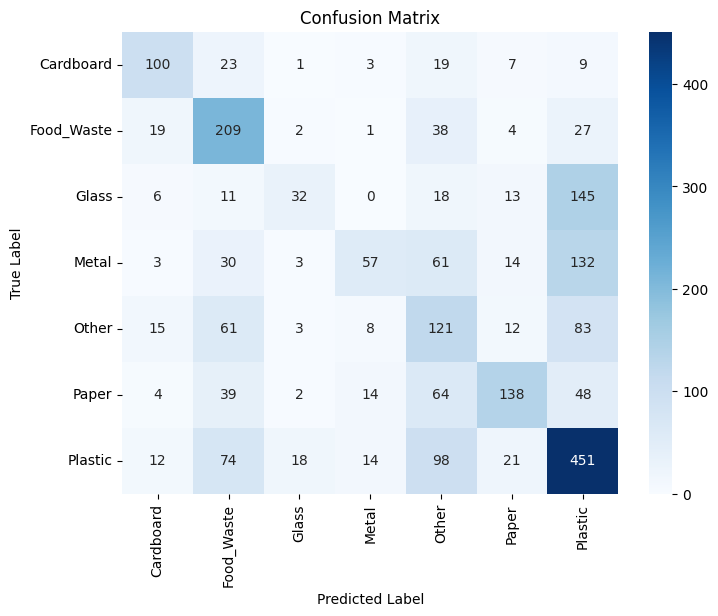

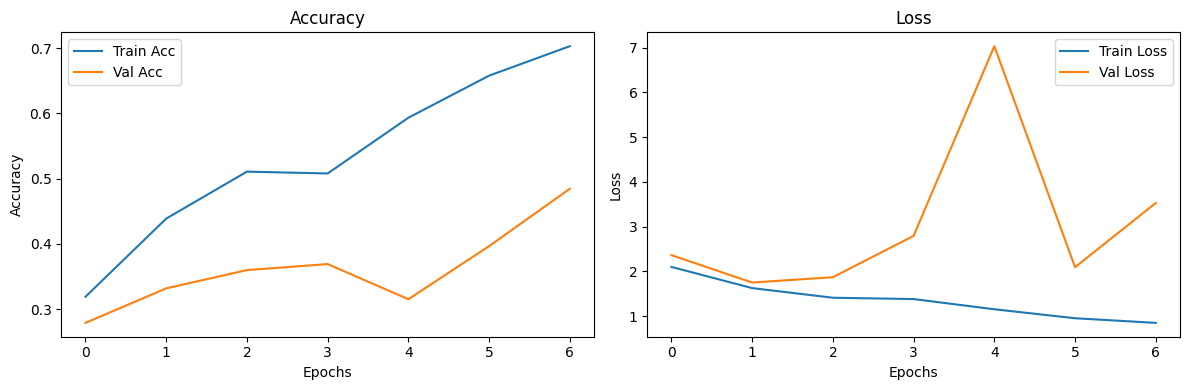

In [ ]:
# Evaluate on the test set; display suitable metrics

# Evaluate on the test set; display suitable metrics

# Load best model saved during training
best_model = load_model('best_model.h5')

# Evaluate on validation data
val_loss, val_accuracy = best_model.evaluate(val_generator, verbose=1)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Get predictions
y_pred_probs = best_model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes

# Get class labels
class_labels = list(val_generator.class_indices.keys())

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Plot training & validation accuracy/loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images




In [ ]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

The confusion matrix shows how the model performs across all classes:

**Best Performing Classes:**

Food_Waste: 232 correct predictions (relatively few misclassifications)

Plastic: 478 correct predictions (though with many misclassifications into other categories)

**Problematic Classes:**

Glass: Only 85 correct predictions with 106 misclassified as Plastic (major confusion)

Metal: 123 correct but significant misclassifications as Plastic (82)

Other: Only 72 correct with many misclassified as Plastic (110)

Paper: 183 correct but notable misclassifications as Plastic (60)

**Common Misclassification Pattern:**

Many classes are frequently misclassified as "Plastic", suggesting the model may be biased toward this category or that plastic waste shares visual features with other waste types.

**Accuracy Metrics**

The model achieved a training accuracy of 0.9 (90%), which appears good at first glance.

However, the confusion matrix reveals significant class imbalance issues and poor performance on several categories despite the high overall accuracy.

**Key Findings**

Class Imbalance Issues:

The number of correct predictions varies greatly (from 72 for "Other" to 478 for "Plastic"), suggesting uneven class representation in the dataset.

Model Biases:

The model shows a strong tendency to classify ambiguous cases as "Plastic", which could indicate either: Plastic waste is overrepresented in training data Plastic waste shares visual features with other categories The model hasn't learned distinctive enough features for other classes

Particular Challenges:

Glass waste seems particularly difficult to classify correctly (only 85 correct vs 106 as Plastic) The "Other" category performs poorly, which is expected but may need better definitio

Recommendations for Improvement

Data-Level Improvements:

Balance the dataset across all categories Review labeling consistency, especially for problematic classes Consider merging or redefining categories that are consistently confused (e.g., Glass and Plastic)

Model-Level Improvements:

Implement class weighting to handle imbalance Try different architectures or add attention mechanisms Apply more aggressive data augmentation for minority classes